# Tf dataset: test output range

In [36]:
import numpy as np
import os
import glob
import cv2
import matplotlib.pyplot as plt
import skimage
import time


## Flatnet tf dataset implementation

In [30]:
sample_paths = glob.glob('/scratch/jreymond/ICCV-2019-FlatNet-Dataset/Display-Captures/measurements/*/*')


In [61]:
def test(raw):
    raw_h, raw_w = raw.shape
    img = np.zeros((raw_h // 2, raw_w // 2, 4), dtype=np.float32)

    img[:, :, 0] = raw[0::2, 0::2]  # r
    img[:, :, 1] = raw[0::2, 1::2]  # gr
    img[:, :, 2] = raw[1::2, 0::2]  # gb
    img[:, :, 3] = raw[1::2, 1::2]  # b

    return img

def plot_bayer(x):
    res = np.zeros((x.shape[0], x.shape[1], 3))
    res[:, :, 0] = x[:, :, 0]
    res[:, :, 1] = (x[:, :, 1] + x[:, :, 2]) /2.0
    res[:, :, 2] = x[:, :, 3]
    return (res / res.max())


In [92]:
path_test = '/scratch/jreymond/ICCV-2019-FlatNet-Dataset/Display-Captures/measurements_cropped/n04192698/n04192698_61010.npy'

arr = np.load(path_test)
print(arr.dtype, arr.shape)
# arr += np.random.normal(size=arr.shape, scale=0)
print(np.min(arr), np.max(arr))

# arr = test(arr)
# arr = plot_bayer(arr)
print(arr.dtype, arr.shape)
arr = arr / 2**16
arr = (arr - 0.5) * 2
print(np.min(arr), np.max(arr))
arr = (arr * (arr > 0) * 2**8).astype(np.uint16)
print(np.min(arr), np.max(arr))
arr = cv2.cvtColor(arr, cv2.COLOR_BAYER_BG2RGB)
plt.imshow(arr)

uint16 (500, 620, 4)
25999 45821
uint16 (500, 620, 4)
-0.206573486328125 0.398345947265625
0 101


error: OpenCV(4.5.1) /tmp/pip-req-build-ddpkm6fn/opencv/modules/imgproc/src/demosaicing.cpp:1721: error: (-215:Assertion failed) scn == 1 && (dcn == 3 || dcn == 4) in function 'demosaicing'


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


min: -0.20657349 max: 0.39834595
float32 (500, 620, 4)


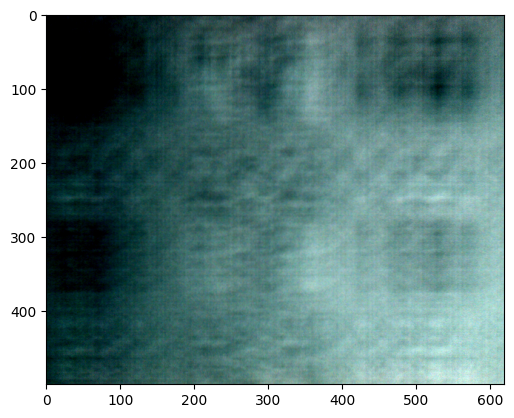

In [70]:
def test_2(filename):
    img = (np.load(filename) / 2**16).astype(np.float32)
    img = (img - 0.5) * 2
    return img

a = test_2(path_test)
print('min:', np.min(a), 'max:', np.max(a))
print(a.dtype, a.shape)
a = plot_bayer(a)
plt.imshow(a)

# Test output values tf dataset

In [42]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
import importlib
import tf_dataset
importlib.reload(tf_dataset)
from tf_dataset import *

import hydra
from hydra import compose, initialize
from omegaconf import OmegaConf

config_name = "wallerlab_reconstruction"

hydra.core.global_hydra.GlobalHydra.instance().clear()
initialize(config_path="configs", job_name="test_app")
config = compose(config_name= config_name)

/tmp/ipykernel_2452786/690452507.py:16: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  initialize(config_path="configs", job_name="test_app")


In [43]:
local_batch_size = config['batch_size']
dataset_config = config['dataset']
indexes = np.arange(dataset_config['len'])

resize_input_shape = None
if config['resize_input'] and config['dataset']['name'] not in['flatnet', 'phlatnet']:
    raise NotImplementedError('Resize input is not implemented for this dataset')

data_args = dict(batch_size=local_batch_size,#config['batch_size'], 
                greyscale=config['greyscale'],
                use_crop=config['use_crop'], 
                seed=config['seed'])

if config['resize_input']:
    resize_input_shape = (config['resize_input_height'], config['resize_input_width'])
    data_args['input_shape'] = resize_input_shape

data_gen = get_tf_dataset(config['dataset']['name'], dataset_config, indexes, data_args)

In [44]:
data = data_gen.get()

i = 0
min_measure = 100000000
max_measure = -100000000
min_target = 100000000
max_target = -100000000

for measure, target in data.take(200):
    i+=1
    if i % 50 == 0:
        print(i)
    min_measure = min(min_measure, np.min(measure.numpy()))
    max_measure = max(max_measure, np.max(measure.numpy()))
    min_target = min(min_target, np.min(target.numpy()))
    max_target = max(max_target, np.max(target.numpy()))
    
print('measure:', 'min:', min_measure, 'max:', max_measure)   
print('target:', 'min:', min_target, 'max:', max_target)
    # print('measure:', 'min:', np.min(measure.numpy()), 'max:', np.max(measure.numpy()), 'shape:', measure.numpy().shape, 'dtype:', measure.numpy().dtype)
    # print('target:', 'min:', np.min(target.numpy()), 'max:', np.max(target.numpy()), 'shape:', target.numpy().shape, 'dtype:', target.numpy().dtype)

Cause: could not parse the source code of <function WallerlabDaloader._map_x.<locals>.<lambda> at 0x7fbdbaea5700>: no matching AST found among candidates:
# coding=utf-8
lambda item: tf.numpy_function(np_load, [item], tf.float32)
# coding=utf-8
lambda item: (item - 0.5) * 2
# coding=utf-8
lambda item: tf.py_function(tf_rgb2gray, [item], tf.float32)
# coding=utf-8
lambda item: item[self.crop['low_h']:self.crop['high_h'], self.crop['low_w']:self.crop['high_w'], :]
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function WallerlabDaloader._map_x.<locals>.<lambda> at 0x7fbdbaea5700>: no matching AST found among candidates:
# coding=utf-8
lambda item: tf.numpy_function(np_load, [item], tf.float32)
# coding=utf-8
lambda item: (item - 0.5) * 2
# coding=utf-8
lambda item: tf.py_function(tf_rgb2gray, [item], tf.float32)
# coding=utf-8
lambda item: item[self.crop['low_h']:self.crop['high_h'], self.crop['low_

2023-06-15 14:48:11.564563: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_7' with dtype string and shape [24999]
	 [[{{node Placeholder/_7}}]]
2023-06-15 14:48:11.565005: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [24999]
	 [[{{node Placeholder/_0}}]]


50
100
150
200
measure: min: -0.007816098 max: 0.7981058
target: min: -0.9990337 max: 1.0


2023-06-15 14:48:18.542302: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-06-15 14:48:18.577159: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
